# CIS 545 Project - Open Foods Dataset
## Exploring and cleaning the dataset

Welcome to our group project. First, we use a small sub-section of the original dataset (which is very large) to test our cleaning and integration pipeline. We will note the data, data-type and more. And depending on the kind of analysis we do, we will project our data onto even smaller dataframes.

Since we want our pipeline to also work on the larger dataset, we will perform all the computations using spark.

# Obstacles
List of obstacles/limitations we have faced so far:  
1. Incomplete data. We were very excited at first about 
certain analysis such as the environmental effects and carbon footprint of various food products. But most of the values in those columns were unfortunately null.  
2. Food products as well as their generic names and labels in different languages: English, French, German, Russian, and more

# Slicing and cleaning the dataset 

## Part 0 - Importing libraries

In [ ]:
# installing our required libraries
%%capture
!apt install libkrb5-dev
!wget https://www-us.apache.org/dist/spark/spark-3.0.1/spark-3.0.1-bin-hadoop3.2.tgz
!tar xf spark-3.0.1-bin-hadoop3.2.tgz
!pip install findspark
!pip install sparkmagic
!pip install pyspark
! pip install pyspark --user
! pip install seaborn --user
! pip install plotly --user
! pip install imageio --user
! pip install folium --user
! pip install geopandas

In [ ]:
%%capture
!apt update
!apt install gcc python-dev libkrb5-dev

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F

import os

spark = SparkSession.builder.appName('545-project').getOrCreate()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model, preprocessing, tree
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, learning_curve, ShuffleSplit
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
sns.set_style("whitegrid")
plt.style.use('seaborn')
%matplotlib inline

#misc
import gc
import time
import warnings
from collections import Counter


#graph section
import networkx as nx

# JSON parsing
import json

# HTML parsing
from lxml import etree
import urllib

# SQLite RDBMS
import sqlite3

# Time conversions
import time

# Parallel processing
# import swifter

# NoSQL DB
from pymongo import MongoClient
from pymongo.errors import DuplicateKeyError, OperationFailure

import os
os.environ["SPARK_HOME"] = "/content/spark-3.0.1-bin-hadoop3.2"
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
import pyspark
from pyspark.sql import SQLContext

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from s

In [ ]:
try:
    if(spark == None):
        spark = SparkSession.builder.appName('Initial').getOrCreate()
        sqlContext=SQLContext(spark)
except NameError:
    spark = SparkSession.builder.appName('Initial').getOrCreate()
    sqlContext=SQLContext(spark)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Part 1 - Loading the data onto Pandas



In [ ]:
file_path = "/content/drive/Shareddrives/545 Final Project/openfoodfacts-products.tsv"
full_df = pd. read_csv(file_path, sep='\t', encoding='utf-8')
full_df.head(1)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,3,5,19,20,24,25,26,27,28,36,37,38,39,48) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,packaging,packaging_tags,brands,brands_tags,categories,categories_tags,categories_en,origins,origins_tags,manufacturing_places,manufacturing_places_tags,labels,labels_tags,labels_en,emb_codes,emb_codes_tags,first_packaging_code_geo,cities,cities_tags,purchase_places,stores,countries,countries_tags,countries_en,ingredients_text,allergens,allergens_en,traces,traces_tags,traces_en,...,vitamin-k_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,3087,http://world-en.openfoodfacts.org/product/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,NaN,NaN,Ferme t'y R'nao,ferme-t-y-r-nao,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en:FR,en:france,France,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# checking number of rows
full_df.shape

(356027, 163)

In [ ]:
full_df.columns.values

array(['code', 'url', 'creator', 'created_t', 'created_datetime',
       'last_modified_t', 'last_modified_datetime', 'product_name',
       'generic_name', 'quantity', 'packaging', 'packaging_tags',
       'brands', 'brands_tags', 'categories', 'categories_tags',
       'categories_en', 'origins', 'origins_tags', 'manufacturing_places',
       'manufacturing_places_tags', 'labels', 'labels_tags', 'labels_en',
       'emb_codes', 'emb_codes_tags', 'first_packaging_code_geo',
       'cities', 'cities_tags', 'purchase_places', 'stores', 'countries',
       'countries_tags', 'countries_en', 'ingredients_text', 'allergens',
       'allergens_en', 'traces', 'traces_tags', 'traces_en',
       'serving_size', 'no_nutriments', 'additives_n', 'additives',
       'additives_tags', 'additives_en', 'ingredients_from_palm_oil_n',
       'ingredients_from_palm_oil', 'ingredients_from_palm_oil_tags',
       'ingredients_that_may_be_from_palm_oil_n',
       'ingredients_that_may_be_from_palm_oil',
   

## Part 2: Projecting useful columns
As we can see, the table has quite a lot of columns. Not all of them carry useful information however, because of two main reasons:
1. The information they carry is mostly not very relevant to our analysis
2. Some columns are almost entirely composed of null values, and most have incomplete data.

Let's see what columns have the most incomplete data

In [ ]:
n_rows = len(full_df)
null_percentage_series = (full_df.isnull().sum()*100/n_rows).sort_values()
x = null_percentage_series[null_percentage_series > 90].index.values
x # all the columns with more than 90% of values being null

array(['emb_codes', 'emb_codes_tags', 'traces', 'traces_en',
       'traces_tags', 'origins', 'origins_tags', 'potassium_100g',
       'polyunsaturated-fat_100g', 'monounsaturated-fat_100g',
       'cities_tags', 'first_packaging_code_geo',
       'ingredients_that_may_be_from_palm_oil_tags', 'vitamin-pp_100g',
       'vitamin-b1_100g', 'vitamin-b2_100g', 'vitamin-d_100g',
       'vitamin-b6_100g', 'ingredients_from_palm_oil_tags',
       'magnesium_100g', 'phosphorus_100g', 'vitamin-b12_100g',
       'vitamin-b9_100g', 'alcohol_100g', 'zinc_100g',
       'fruits-vegetables-nuts_100g', 'folates_100g',
       'pantothenic-acid_100g', 'copper_100g', 'manganese_100g',
       'vitamin-e_100g', 'cocoa_100g', 'selenium_100g',
       'omega-3-fat_100g', 'vitamin-k_100g', 'energy-from-fat_100g',
       'polyols_100g', 'fruits-vegetables-nuts-estimate_100g',
       'biotin_100g', 'starch_100g', 'iodine_100g',
       'carbon-footprint_100g', '-lactose_100g', 'omega-6-fat_100g',
       '-alpha-li

In [ ]:
len(x)

100

### Removing mostly empty columns

100 columns have more than 90% of their total values as null, so we can drop these columns for now.

Let's see what column that leaves us with now.

In [ ]:
lesscolumns_df = full_df[null_percentage_series[null_percentage_series <= 90].index]
lesscolumns_df.head(5)

,last_modified_t,last_modified_datetime,creator,created_t,created_datetime,code,url,states,states_en,states_tags,countries_en,countries_tags,countries,product_name,brands,brands_tags,energy_100g,proteins_100g,salt_100g,sodium_100g,ingredients_text,ingredients_that_may_be_from_palm_oil_n,ingredients_from_palm_oil_n,additives_n,additives,fat_100g,carbohydrates_100g,sugars_100g,saturated-fat_100g,nutrition_grade_fr,nutrition-score-uk_100g,nutrition-score-fr_100g,fiber_100g,serving_size,additives_tags,additives_en,cholesterol_100g,trans-fat_100g,calcium_100g,vitamin-c_100g,iron_100g,vitamin-a_100g,pnns_groups_2,pnns_groups_1,quantity,categories_en,categories,categories_tags,main_category,main_category_en,packaging,packaging_tags,image_url,image_small_url,purchase_places,labels_en,labels_tags,labels,generic_name,stores,manufacturing_places,manufacturing_places_tags,allergens
0,1474103893,2016-09-17T09:18:13Z,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,3087,http://world-en.openfoodfacts.org/product/0000...,"en:to-be-completed, en:nutrition-facts-to-be-c...","To be completed,Nutrition facts to be complete...","en:to-be-completed,en:nutrition-facts-to-be-co...",France,en:france,en:FR,Farine de blé noir,Ferme t'y R'nao,ferme-t-y-r-nao,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1kg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1489069957,2017-03-09T14:32:37Z,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,4530,http://world-en.openfoodfacts.org/product/0000...,"en:to-be-completed, en:nutrition-facts-complet...","To be completed,Nutrition facts completed,Ingr...","en:to-be-completed,en:nutrition-facts-complete...",United States,en:united-states,US,Banana Chips Sweetened (Whole),NaN,NaN,2243.0,3.57,0.00000,0.000,"Bananas, vegetable oil (coconut oil, corn oil ...",0.0,0.0,0.0,[ bananas -> en:bananas ] [ vegetable-oil -...,28.57,64.29,14.29,28.57,d,14.0,14.0,3.6,28 g (1 ONZ),NaN,NaN,0.018,0.0,0.000,0.0214,0.00129,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1489069957,2017-03-09T14:32:37Z,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,4559,http://world-en.openfoodfacts.org/product/0000...,"en:to-be-completed, en:nutrition-facts-complet...","To be completed,Nutrition facts completed,Ingr...","en:to-be-completed,en:nutrition-facts-complete...",United States,en:united-states,US,Peanuts,Torn & Glasser,torn-glasser,1941.0,17.86,0.63500,0.250,"Peanuts, wheat flour, sugar, rice flour, tapio...",0.0,0.0,0.0,[ peanuts -> en:peanuts ] [ wheat-flour -> ...,17.86,60.71,17.86,0.00,b,0.0,0.0,7.1,28 g (0.25 cup),NaN,NaN,0.000,0.0,0.071,0.0000,0.00129,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1489055731,2017-03-09T10:35:31Z,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,16087,http://world-en.openfoodfacts.org/product/0000...,"en:to-be-completed, en:nutrition-facts-complet...","To be completed,Nutrition facts completed,Ingr...","en:to-be-completed,en:nutrition-facts-complete...",United States,en:united-states,US,Organic Salted Nut Mix,Grizzlies,grizzlies,2540.0,17.86,1.22428,0.482,"Organic hazelnuts, organic cashews, organic wa...",0.0,0.0,0.0,[ organic-hazelnuts -> en:organic-hazelnuts ...,57.14,17.86,3.57,5.36,d,12.0,12.0,7.1,28 g (0.25 cup),NaN,NaN,NaN,NaN,0.143,NaN,0.00514,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1489055653,2017-03-09T10:34:13Z,usda-ndb-import,1489055653,2017-03-09T10:34:13Z,16094,http://world-en.openfoodfacts.org/product/0000...,"en:to-be-completed, en:nutrition-facts-complet...","To be completed,Nutrition facts completed,Ingr...","en:to-be-completed,en:nutrition-facts-complete...",United States,en:united-states,US,Organic Polenta,Bob's Red Mill,bob-s-red-mill,1552.0,8.57,NaN,NaN,Organic polenta,0.0,0.0,0.0,[ organic-polenta -> en:organic-polenta ] [...,1.43,77.14,NaN,NaN,NaN,NaN,NaN,5

### Section to explore various columns

In [ ]:
column_name = 'pnns_groups_1'

In [ ]:
len(lesscolumns_df[column_name].dropna().drop_duplicates())

14

In [ ]:
# checking the percentage of null values
n_rows = len(lesscolumns_df)
lesscolumns_df[column_name].isnull().sum() / n_rows

0.6376510770250571

In [ ]:
# exploring unique non-null values
lesscolumns_df[column_name].dropna().drop_duplicates().head(100)

47                        unknown
176         Fruits and vegetables
177                 Sugary snacks
179          Cereals and potatoes
185                     Beverages
187               Composite foods
188                Fish Meat Eggs
232                Fat and sauces
475       Milk and dairy products
512         fruits-and-vegetables
558                  Salty snacks
27825               sugary-snacks
184447       cereals-and-potatoes
309568               salty-snacks
Name: pnns_groups_1, dtype: object

### Picking relevant columns

In [ ]:
lesscolumns_df.columns.values

array(['last_modified_t', 'last_modified_datetime', 'creator',
       'created_t', 'created_datetime', 'code', 'url', 'states',
       'states_en', 'states_tags', 'countries_en', 'countries_tags',
       'countries', 'product_name', 'brands', 'brands_tags',
       'energy_100g', 'proteins_100g', 'salt_100g', 'sodium_100g',
       'ingredients_text', 'ingredients_that_may_be_from_palm_oil_n',
       'ingredients_from_palm_oil_n', 'additives_n', 'additives',
       'fat_100g', 'carbohydrates_100g', 'sugars_100g',
       'saturated-fat_100g', 'nutrition_grade_fr',
       'nutrition-score-uk_100g', 'nutrition-score-fr_100g', 'fiber_100g',
       'serving_size', 'additives_tags', 'additives_en',
       'cholesterol_100g', 'trans-fat_100g', 'calcium_100g',
       'vitamin-c_100g', 'iron_100g', 'vitamin-a_100g', 'pnns_groups_2',
       'pnns_groups_1', 'quantity', 'categories_en', 'categories',
       'categories_tags', 'main_category', 'main_category_en',
       'packaging', 'packaging_tags'

Now that we have a significantly smaller number of columns to work with, we can just look at all the remaining column and decide which ones we will need in our analysis. We plan to do the following analysis for now: 

Exploration:
1. Analyse the economics of food production and companies - which products/industries invite the most competition  
> product_name, brands_tags, main_category
2. Explore various vfood categories 
> pnns_groups1, pnns_groups2, main_category
3. Identifying the main ingredients used 
> ingredients
5. Look at the food scores associated with each of the countries in the database
> countries, food health score

Modelling:  
Is it possible to tell the category of a food product based on it's nutrient composition (protein, fat, carbohydrate, fiber, etc.) and other details?

Based on the analysis we plan to do, we can pick the columns that are most relevant.


In [ ]:
# most relevant columns
relevant_columns = ['countries_en','product_name', 'brands_tags',
       'ingredients_text', 'fat_100g', 'carbohydrates_100g', 'sugars_100g',
       'saturated-fat_100g', 'nutrition_grade_fr',
       'nutrition-score-fr_100g', 'fiber_100g','serving_size',
       'cholesterol_100g', 'trans-fat_100g', 'pnns_groups_2', 'proteins_100g',
       'pnns_groups_1', 'main_category', 'salt_100g', 
       'packaging', 'generic_name', 'stores']

In [ ]:
working_df = lesscolumns_df[relevant_columns]
working_df.head(10)

,countries_en,product_name,brands_tags,ingredients_text,fat_100g,carbohydrates_100g,sugars_100g,saturated-fat_100g,nutrition_grade_fr,nutrition-score-fr_100g,fiber_100g,serving_size,cholesterol_100g,trans-fat_100g,pnns_groups_2,proteins_100g,pnns_groups_1,main_category,salt_100g,packaging,generic_name,stores
0,France,Farine de blé noir,ferme-t-y-r-nao,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,United States,Banana Chips Sweetened (Whole),NaN,"Bananas, vegetable oil (coconut oil, corn oil ...",28.57,64.29,14.29,28.57,d,14.0,3.6,28 g (1 ONZ),0.018,0.0,NaN,3.57,NaN,NaN,0.00000,NaN,NaN,NaN
2,United States,Peanuts,torn-glasser,"Peanuts, wheat flour, sugar, rice flour, tapio...",17.86,60.71,17.86,0.00,b,0.0,7.1,28 g (0.25 cup),0.000,0.0,NaN,17.86,NaN,NaN,0.63500,NaN,NaN,NaN
3,United States,Organic Salted Nut Mix,grizzlies,"Organic hazelnuts, organic cashews, organic wa...",57.14,17.86,3.57,5.36,d,12.0,7.1,28 g (0.25 cup),NaN,NaN,NaN,17.86,NaN,NaN,1.22428,NaN,NaN,NaN
4,United States,Organic Polenta,bob-s-red-mill,Organic polenta,1.43,77.14,NaN,NaN,NaN,NaN,5.7,35 g (0.25 cup),NaN,NaN,NaN,8.57,NaN,NaN,NaN,NaN,NaN,NaN
5,United States,Breadshop Honey Gone Nuts Granola,unfi,"Rolled oats, grape concentrate, expeller press...",18.27,63.46,11.54,1.92,NaN,NaN,7.7,52 g (0.5 cup),NaN,NaN,NaN,13.46,NaN,NaN,NaN,NaN,NaN,NaN
6,United States,Organic Long Grain White Rice,lundberg,Organic long grain white rice,NaN,80.00,NaN,NaN,NaN,NaN,NaN,45 g (0.25 cup),NaN,NaN,NaN,8.89,NaN,NaN,NaN,NaN,NaN,NaN
7,United States,Organic Muesli,daddy-s-muesli,"Org oats, org hemp granola (org oats, evaporat...",18.75,57.81,15.62,4.69,c,7.0,9.4,64 g (0.5 cup),NaN,NaN,NaN,14.06,NaN,NaN,0.13970,NaN,NaN,NaN
8,United States,Organic Dark Chocolate Minis,equal-exchange,"Organic chocolate liquor, organic raw cane sug...",37.50,55.00,42.50,22.50,NaN,NaN,7.5,40 g (40 g),NaN,NaN,NaN,5.00,NaN,NaN,NaN,NaN,NaN,NaN
9,United States,Organic Sunflower Oil,napa-valley-naturals,"Organic expeller pressed, refined high oleic s...",100.00,NaN,NaN,7.14,NaN,NaN,NaN,14 g (1 Tbsp),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Exploratory Data Analysis



## Most represented countries

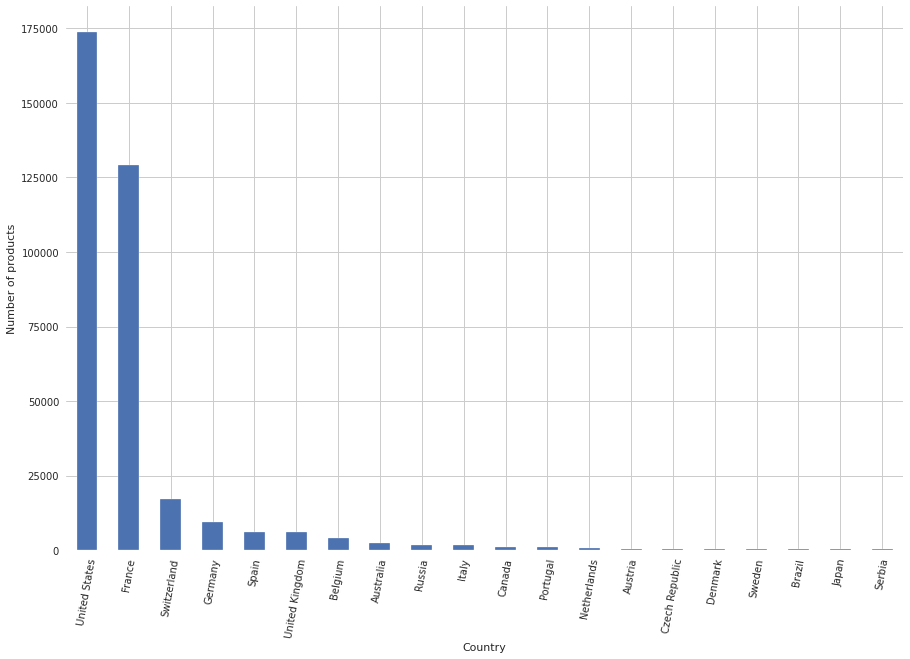

In [ ]:
sns.set_style("whitegrid")
top_countries = working_df['countries_en'].str.split(",").explode().value_counts().head(20)
plt.figure(figsize=(15,10))
top_countries.plot.bar()
plt.xticks(rotation=80)
plt.xlabel("Country")
plt.ylabel("Number of products")
plt.show()

The US and France cover a significant portion of the dataset. A large portion of the data being from France might make analysis difficult for us, given the data for the food items will be expressed in French.

## Most represented brands

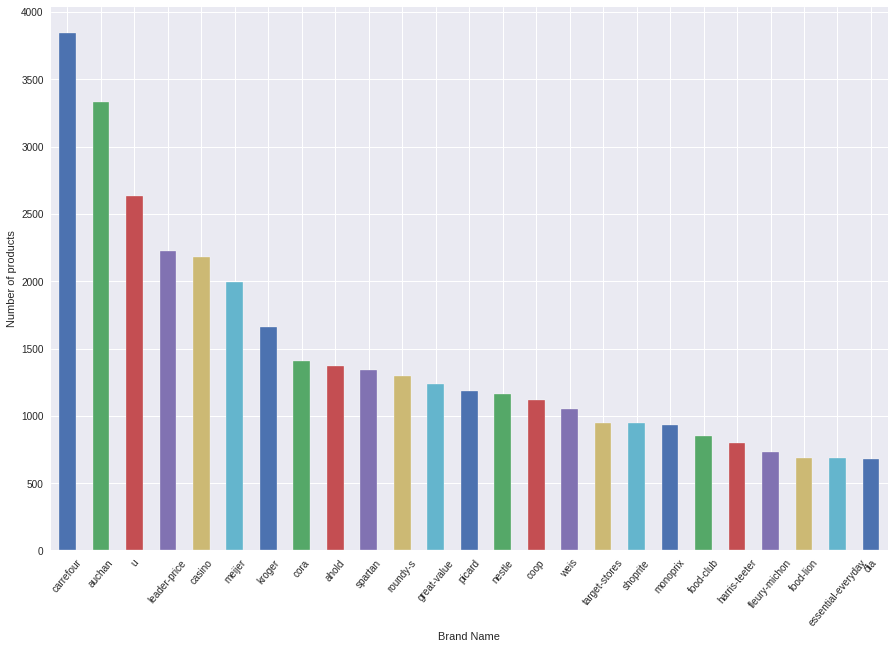

In [ ]:
sns.set_style("whitegrid")
plt.style.use("seaborn")
top_brands = working_df['brands_tags'].value_counts().head(25)
plt.figure(figsize=(15,10))
top_brands.plot(kind='bar', color=sns.color_palette())
plt.xticks(rotation=50)
plt.xlabel("Brand Name")
plt.ylabel("Number of products")
plt.show()

Even though US has the most occurance in the table, much of the largest brands seem to be French Multinational Companies.

## Exploring the different food categories

Let's limit our categories to ones that are in English

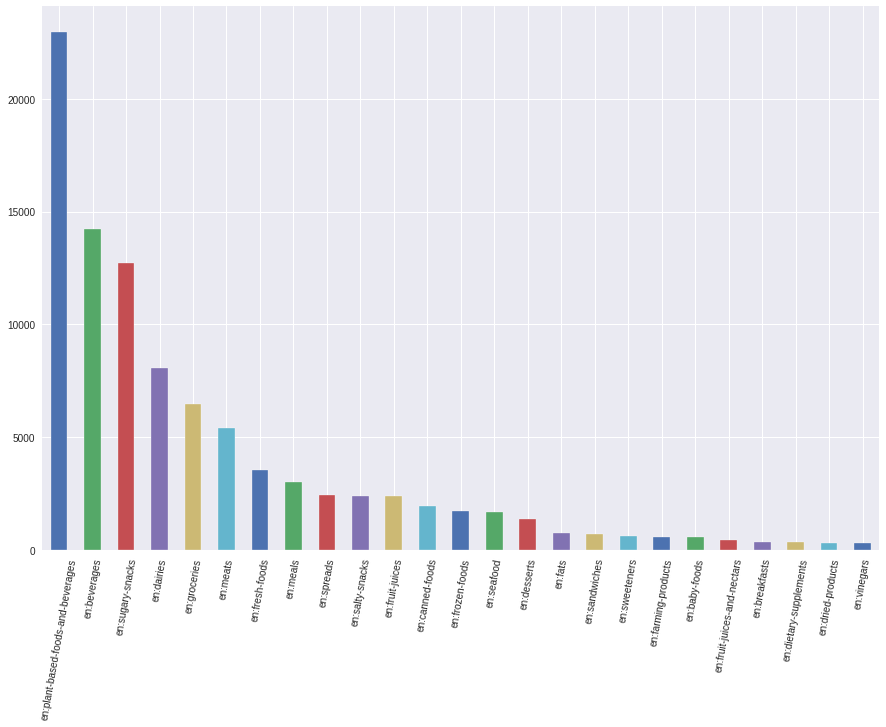

In [ ]:
notnullcategory_df = working_df[working_df['main_category'].notnull()]
notnull_eng_category = notnullcategory_df[notnullcategory_df['main_category'].str.contains("en:")]
plt.figure(figsize=(15,10))
notnull_eng_category["main_category"].value_counts().head(25).plot(kind='bar', color=sns.color_palette())
plt.xticks(rotation=80)
plt.show()

This shows that a large portion of the food products are plant based foods and beverages. Veganism surely is gaining popularity!

## Most competitive food industry
We count number of unique brands per food industry,and notice similar kind of figures for each categories as above.

More brands in an industry could represent more competition in those respective markets. We do notice some differences though. The graph above shows that there are more food items in the category of freshfoods than in spreads, ho

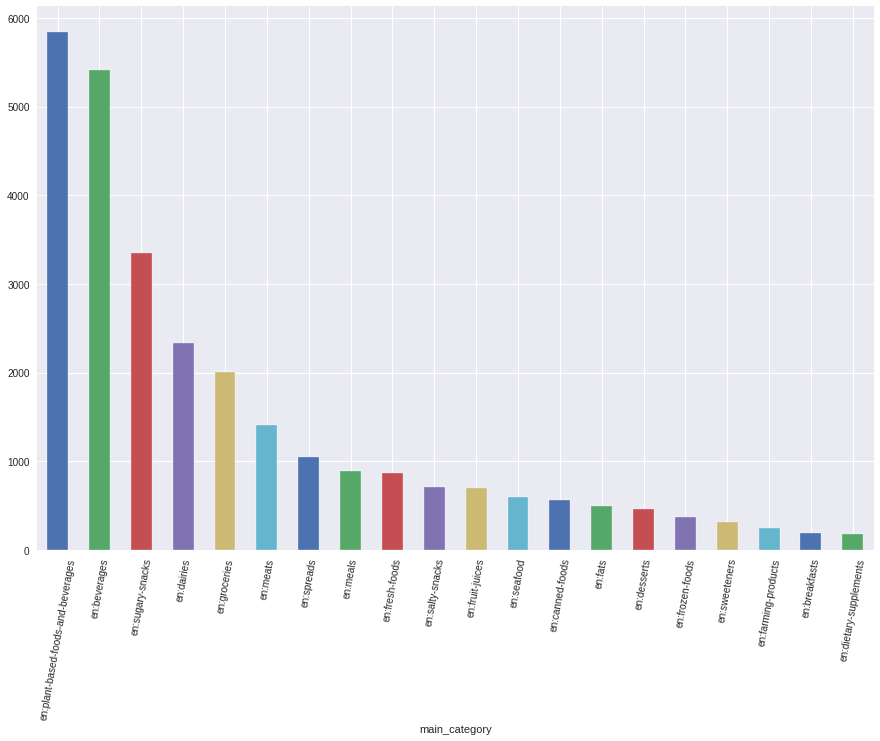

In [ ]:
plt.figure(figsize=(15,10))
working_df.groupby('main_category')['brands_tags'].nunique().sort_values(
    ascending=False).head(20).plot(kind='bar', color=sns.color_palette())
plt.xticks(rotation=80)
plt.show()

## Ingredients

let's see what ingredients we are dealing with

In [ ]:
working_df['ingredients_text'].dropna().head(1).values

array(['Bananas, vegetable oil (coconut oil, corn oil and/or palm oil) sugar, natural banana flavor.'],
      dtype=object)

Each ingredient data item is a string in the format:  
> Bananas, vegetable oil (coconut oil, corn oil and/or palm oil) sugar, natural banana flavor

Since vegetable oil is then once again expanded upon, we can remove the terms vegetable and oil from the list of ingredients/corpus. 

In [ ]:
stop = ['vegetable', 'oil', 'organic', 'contains', 'powder', 'concentrate', 
        'expeller', 'pressed']

ingredients_series = working_df['ingredients_text'].dropna().str.lower()
# remove special characters
ingredients_series = ingredients_series.str.replace("[^a-zA-Z]", " ")
ingredients_series = ingredients_series.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [ ]:
ingredients_series

1         bananas coconut corn and or palm sugar natural...
2         peanuts wheat flour sugar rice flour tapioca s...
3         hazelnuts cashews walnuts almonds sunflower se...
4                                                   polenta
5         rolled oats grape canola sunflower seeds almon...
                                ...                        
356011                                                 miel
356017    th vert ar me naturel bergamote avec autres ar...
356019      viande d oie graisse de canard pices sel poivre
356022                     peppermint lemon grass spearmint
356026    citric acid maltodextrin instant tea aspartame...
Name: ingredients_text, Length: 283893, dtype: object

In [ ]:
ingredients_words = ingredients_series.str.split(" ").explode()
# removing items whose length is less than 4
ingredients_words = ingredients_words[ingredients_words.str.len() > 3]

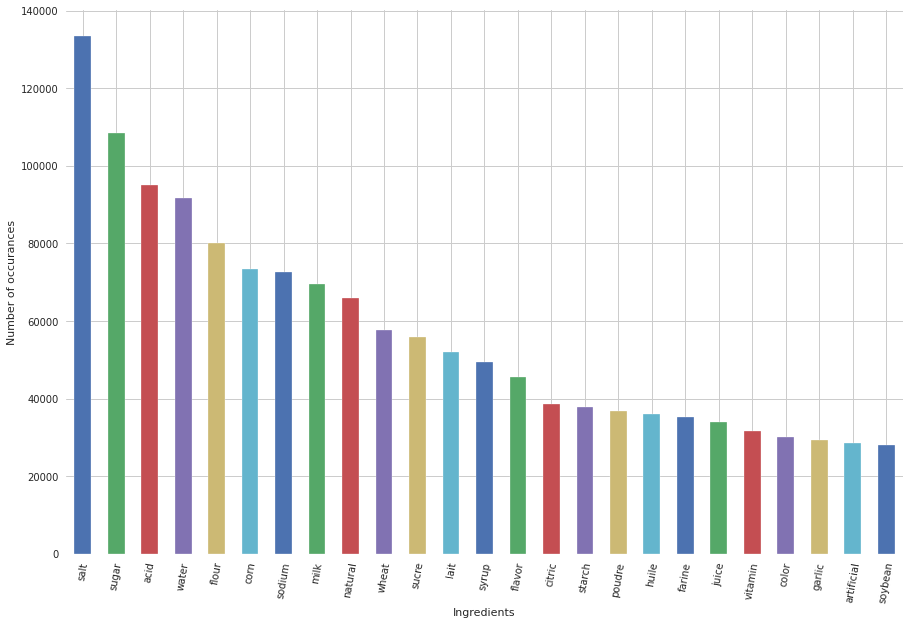

In [ ]:
sns.set_style("whitegrid")
ingredients_to_plot = ingredients_words.value_counts().sort_values(ascending=False).head(25)
plt.figure(figsize=(15,10))
ingredients_to_plot.plot(kind='bar', color=sns.color_palette())
plt.xticks(rotation=80)
plt.xlabel("Ingredients")
plt.ylabel("Number of occurances")
plt.show()

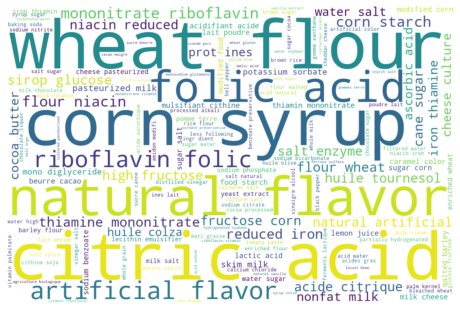

In [ ]:
ingredients_string = ' '.join(ingredients_words.to_list())
wordcloud = WordCloud(width=1440, height=960, max_words=150, background_color="white").generate(ingredients_string)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Visualizing health scores on a Map

Let's explore the average health score associated with each country depending on the health score of the products that originated in those countries.

In [ ]:
# Map Viz
import json
import geopandas as gpd

# Loading countries polygons
geo_path = '/content/drive/Shareddrives/545 Final Project/world-countries.json'
country_geo = json.load(open(geo_path))
gpf = gpd.read_file(geo_path)
gpf.tail(10)

,id,name,geometry
167,USA,United States of America,"MULTIPOLYGON (((-155.54211 19.08348, -155.6881..."
168,UZB,Uzbekistan,"POLYGON ((66.51861 37.36278, 66.54615 37.97469..."
169,VEN,Venezuela,"POLYGON ((-71.33158 11.77628, -71.36001 11.539..."
170,VNM,Vietnam,"POLYGON ((108.05018 21.55238, 106.71507 20.696..."
171,VUT,Vanuatu,"MULTIPOLYGON (((167.84488 -16.46633, 167.51518..."
172,PSE,West Bank,"POLYGON ((35.54566 32.39399, 35.54525 31.78251..."
173,YEM,Yemen,"POLYGON ((53.10857 16.65105, 52.38521 16.38241..."
174,ZAF,South Africa,"POLYGON ((31.52100 -29.25739, 31.32556 -29.401..."
175,ZMB,Zambia,"POLYGON ((32.75937 -9.23060, 33.23139 -9.67672..."
176,ZWE,Zimbabwe,"POLYGON ((31.19141 -22.25151, 30.65986 -22.151..."


In [ ]:
map_df = working_df[['countries_en', 'brands_tags', 'product_name', 'nutrition-score-fr_100g']].copy()
map_df['countries_en'] = map_df['countries_en'].str.split(",")
map_df = map_df.explode('countries_en').dropna()
map_df['countries_en'] = map_df['countries_en'].str.replace('United States', 'United States of America')
map_df.head(5)

,countries_en,brands_tags,product_name,nutrition-score-fr_100g
2,United States of America,torn-glasser,Peanuts,0.0
3,United States of America,grizzlies,Organic Salted Nut Mix,12.0
7,United States of America,daddy-s-muesli,Organic Muesli,7.0
12,United States of America,sunridge,Zen Party Mix,12.0
15,United States of America,grizzlies,Cinnamon Nut Granola,0.0


In [ ]:
nmap_df = map_df.groupby(by=['countries_en']).mean('nutrition-score-fr_100g').reset_index()
nmap_df.columns = ['country', 'avg-nutrition-score']
nmap_df.head(5)

,country,avg-nutrition-score
0,Albania,6.285714
1,Algeria,15.055556
2,Allemagne,5.000000
3,Andorra,8.125000
4,Argentina,13.666667


In [ ]:
map_plotting_df = nmap_df.merge(gpf, right_on='name', left_on='country')
map_plotting_df.tail(10)

,country,avg-nutrition-score,id,name,geometry
79,Taiwan,7.055556,TWN,Taiwan,"POLYGON ((121.77782 24.39427, 121.17563 22.790..."
80,Thailand,9.952381,THA,Thailand,"POLYGON ((102.58493 12.18660, 101.68716 12.645..."
81,Tunisia,16.913043,TUN,Tunisia,"POLYGON ((9.48214 30.30756, 9.05560 32.10269, ..."
82,Turkey,12.900000,TUR,Turkey,"MULTIPOLYGON (((36.91313 41.33536, 38.34766 40..."
83,Ukraine,23.000000,UKR,Ukraine,"POLYGON ((31.78600 52.10168, 32.15941 52.06127..."
84,United Arab Emirates,11.000000,ARE,United Arab Emirates,"POLYGON ((51.57952 24.24550, 51.75744 24.29407..."
85,United Kingdom,8.259067,GBR,United Kingdom,"MULTIPOLYGON (((-5.66195 54.55460, -6.19789 53..."
86,United States of America,9.454410,USA,United States of America,"MULTIPOLYGON (((-155.54211 19.08348, -155.6881..."
87,Vanuatu,-0.500000,VUT,Vanuatu,"MULTIPOLYGON (((167.84488 -16.46633, 167.51518..."
88,Yemen,21.000000,YEM,Yemen,"POLYGON ((53.10857 16.65105, 52.38521 16.38241..."


### Map

In [ ]:
import folium
world_map = folium.Map(location=[0, 0], zoom_start=2)
folium.Choropleth(
    geo_data = country_geo,                  #json
    name ='choropleth',                  
    data = map_plotting_df,                     
    columns = ['id', 'avg-nutrition-score'], #columns to work on
    key_on ='feature.id',
    fill_color ='YlGnBu',     #I passed colors Yellow,Green,Blue
    fill_opacity = 0.7,
    line_opacity = 0.2,
   legend_name = "Average Nutrition Scale"
).add_to(world_map)
world_map

# Models

We use supervised learning models to predict food category of products based on their nutritional content and brand tags. We further combine supervised and unsupervised learning to fill in the gaps and reclassify 'unknown' labels.

We start out with the question: How accurately can we predict food category based on nutritional content and brand tags? Additionally, is 'unknown' a class in itself or can further analysis give us more information to reclassify datapoints in unknown food category?

## Use nutrient composition and brand to predict food category

We make use of the following fields to predict food category (pnns_group_2):
   
> fat_100g, carbohydrates_100g, sugars_100g, saturated-fat_100g, fiber_100g, cholesterol_100g, trans-fat_100g, proteins_100g, salt_100g, brands_tags



## Prepare dataframe for training and testing

Below, we prepare the dataset for training and testing. More specifically, we define a *preprocess* function that takes in a dataframe with all the columns that *working_df* has and,


1.   Project relevant columns
2.   Change the datatype of categorical columns to numerical codes
3.   Fill null values with 0: We treat a *NaN* for nutrients the same as if the value were 0
4.   Normalize the labels: We noticed that same categories were treated different because they were formatted differently. For instance, 'fruits-and-vegetables' is in the same category as 'Fruits and vegetables'.
5.   We also notices that there was significant class imbalance between different categories. So we used [RandomOverSampler](https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.RandomOverSampler.html) to oversample from classes with less data points.



In [ ]:
def filter_y(y):
  if y == 'fruits-and-vegetables':
    return 'Fruits and vegetables'
  elif y == 'sugary-snacks':
    return 'Sugary snacks'
  elif y == 'cereals-and-potatoes':
    return 'Cereals and potatoes'
  elif y == 'salty-snacks':
    return 'Salty snacks'
  
  return y

In [ ]:
def preprocess(X, oversample=True):
  # Project only the relevant columns from input dataframe X
  X = X[["pnns_groups_1", "brands_tags", "fat_100g", "carbohydrates_100g", "sugars_100g", \
         "saturated-fat_100g", "fiber_100g", "cholesterol_100g", "trans-fat_100g", "proteins_100g", "salt_100g"]]
  X["brands_tags"] = X["brands_tags"].astype('category').cat.codes
  X = X.fillna(0)
  y = X['pnns_groups_1']

  # Drop the labels from X
  X = X.drop('pnns_groups_1', axis=1)

  # Normalize labels
  y = y.apply(filter_y)

  # Since the classes are unbalanced, we use oversampler
  X_balanced, y_balanced = [], []
  if oversample:
    oversampler = RandomOverSampler()
    X_balanced, y_balanced = oversampler.fit_resample(X, y)
  
  return X, y, X_balanced, y_balanced

## Train test split

Below, we filter out rows that have *NaN* or *unknown* as labels and call preprocess on the remaining rows to get our final dataset. We then split it into train and test set. Since the dataset is small, we separate only 5% as test set

In [ ]:
X = working_df[ working_df['pnns_groups_1'].notnull()][working_df['pnns_groups_1'] != 'unknown']

X, y, X_balanced, y_balanced = preprocess(X)

X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.05)

Counter(y_train)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Counter({'Beverages': 14583,
         'Cereals and potatoes': 14575,
         'Composite foods': 14639,
         'Fat and sauces': 14632,
         'Fish Meat Eggs': 14566,
         'Fruits and vegetables': 14603,
         'Milk and dairy products': 14619,
         'Salty snacks': 14601,
         'Sugary snacks': 14586})

## Plot learning curve

Below is a copy of the [helper function](https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html) sklearn provides to plot learning curve for various estimators.

In [ ]:
@ignore_warnings(category=ConvergenceWarning)
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5), first=True):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    i = 0

    # Plot learning curve
    axes[i].grid()
    axes[i].fill_between(train_sizes, train_scores_mean - train_scores_std,
                        train_scores_mean + train_scores_std, alpha=0.1,
                        color="r")
    axes[i].fill_between(train_sizes, test_scores_mean - test_scores_std,
                        test_scores_mean + test_scores_std, alpha=0.1,
                        color="g")
    axes[i].plot(train_sizes, train_scores_mean, 'o-', color="r",
                label="Training score")
    axes[i].plot(train_sizes, test_scores_mean, 'o-', color="g",
                label="Cross-validation score")
    axes[i].legend(loc="best")
    i += 1

    # Plot n_samples vs fit_times
    axes[i].grid()
    axes[i].plot(train_sizes, fit_times_mean, 'o-')
    axes[i].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[i].set_xlabel("Training examples")
    axes[i].set_ylabel("fit_times")
    axes[i].set_title("Scalability of the model")
    i += 1

    # Plot fit_time vs score
    axes[i].grid()
    axes[i].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[i].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[i].set_xlabel("fit_times")
    axes[i].set_ylabel("Score")
    axes[i].set_title("Performance of the model")

    return plt

## Logistic regression

We use multi-class logistic regression as our baseline model. We get a training accuracy of 62% and test accuracy of 60%. Note that this is better than random prediction which would have an accuracy of 14%. However, we show later on that we can do better

In [ ]:
X_scaled = preprocessing.scale(X_train)
model = linear_model.LogisticRegression(penalty='elasticnet', solver='saga', multi_class='multinomial', C=2, l1_ratio=0.5).fit(X_scaled, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [ ]:
print("Training acc: ")
print(model.score(X_scaled, y_train))

X_scaled_test = preprocessing.scale(X_test)
print("Test acc: ")
print(model.score(X_scaled_test, y_test))

Training acc: 
0.6224696356275303
Test acc: 
0.6098019372560358


## Decision Tree

The second model we tried is Decision tree. This model gives us an accuracy of 96% in the train set and 90% in the test set which is significantly better than our base Logistic Regression Model.

In [ ]:
model = tree.DecisionTreeClassifier().fit(X_train, y_train)

In [ ]:
print(model.score(X_train, y_train))
model.score(X_test, y_test)

0.9637606161151867


0.9019806274396415

## Performance of different supervised models

Below we compare the performance of three different classification models we trained on the dataset, namely Logistic Regression, Decision Tree and Random Forest Classifier.

We use **cross validation** to make sure that our model doesn't overfit.
More specifically, we use 5-fold cross-validation to avoid overfitting and plot  the learning curve along with scalability and performance.

### Analysis
We note that Logistic Regression did not converge on the dataset, but we did get stable coefficients. Thus, the learning curve for logistic regression is empty.
Additionally, we also see that the training accuracy for decision tree starts out slightly higher than random forest classifier whereas the cross validation score for decision tree starts out lower. This can be explained by the fact that random forest classifier learns quicker than decision tree.

In terms of scalability, all three models show linear increase in time complexity over sample size. However, looking at the absolute values, logistic regression took the longest time and decision tree took the shortest to train. Random forest classifier took more than twice as long to train than decision trees. This difference in time between Decision Trees and Random Forest can be explained by the fact tha we used 10 estimators for randome forest.

Finally, in terms of performance, logistice regression is in the bottom with only around 62% train accuracy, followed by decision tree with 90% accuracy followed by random forest with accuracy slightly higher than 90%. This dicrepancy can be explained by the fact that we also have categorical feature like brand tags that logistic regression cannot handle as well as decision tree. Additionally, because of model complexity, rarndom forest classifier outperforms decision tree.

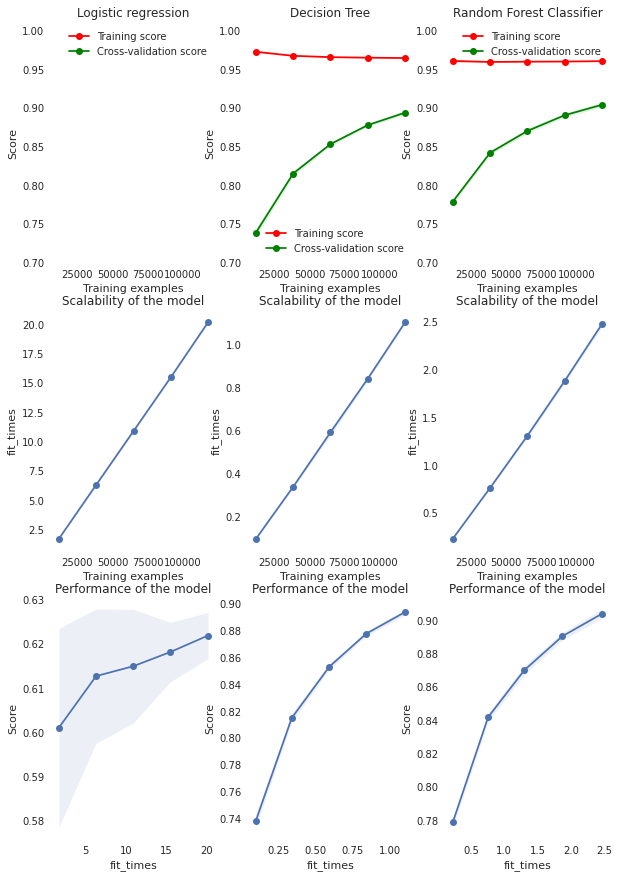

In [ ]:
X_scaled = preprocessing.scale(X_train)
model_logistic = linear_model.LogisticRegression(penalty='elasticnet', solver='saga', multi_class='multinomial', C=2, l1_ratio=0.5)#.fit(X_scaled, y_train)
model_dec = tree.DecisionTreeClassifier()
model_random = RandomForestClassifier(n_estimators=10)
cv = ShuffleSplit(n_splits=10, test_size=0.1)

fig, axes = plt.subplots(3, 3, figsize=(10, 15))
plot_learning_curve(model_logistic, "Logistic regression", X_scaled, y_train, axes=axes[:, 0], cv=cv, ylim=[0.7, 1.01])
plot_learning_curve(model_dec, "Decision Tree", X_train, y_train, axes=axes[:, 1], cv=cv, ylim=[0.7, 1.01])
plot_learning_curve(model_random, "Random Forest Classifier", X_train, y_train, axes=axes[:, 2], cv=cv, ylim=[0.7, 1.01])

plt.show()

## K-Means Clustering

As a way to approach the problem differently, we use k means clustering as our unsupervised learning method. We want to know whether unknown is truly it's own class/label or is it because of lack of data and or analysis.

To perform clustering, we first run a PCA analysis and choose the appropriate number of principal components. This reduces computation cost and has the added benefit of being able to visualize more conveniently. Then, we try clustering with as many clusters as there are labels, i.e., 7. Finally, we check to see if all the rows with unknown food category fit into these 7 clusters or form a separate 8th one.

### PCA for clustering

Below is the plot for proportion on unexplained variance against number of components. We note that the first principal component explains away more than 99% of variance. Thus, we choose 2 principal components to perform clustering on

[0.99994781 0.99997358 0.99998815 0.99999326 0.99999605 0.99999838
 0.9999996  1.         1.        ]


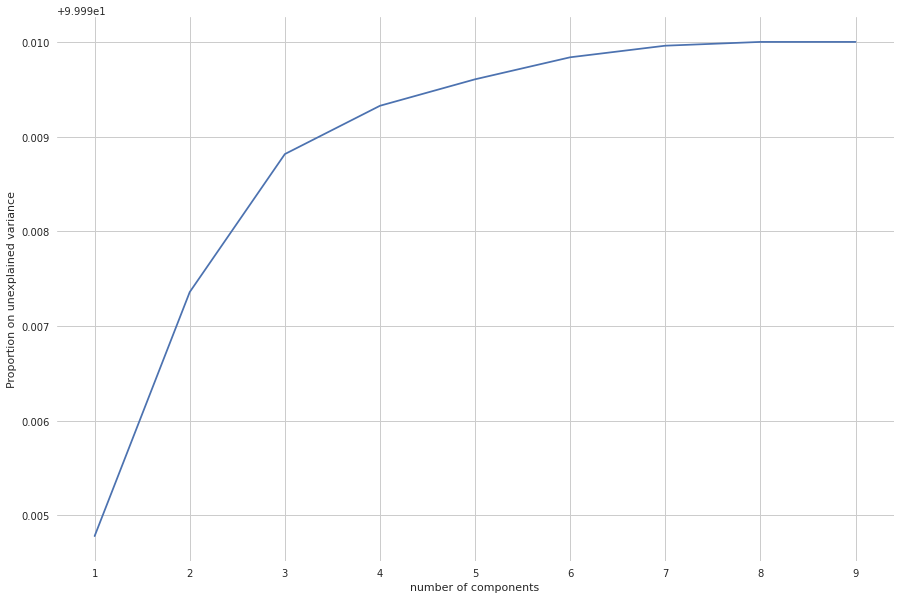

In [ ]:
pca_model = PCA(n_components=9).fit(X_balanced)

y_axis = np.cumsum(pca_model.explained_variance_ratio_)
print(y_axis)
x_axis = [i for i in range(1, len(y_axis) + 1)]

plt.figure(figsize=(15,10))
plt.plot(x_axis, y_axis * 100)
plt.xlabel("number of components")
plt.ylabel("Proportion on unexplained variance")
plt.show()

In [ ]:
pca = PCA (n_components=2).fit(X_balanced)

### K-Means

In the code cell below, we do the following:

1. Transform X_train to X_pca using the pca model we trained above.
2. Train a K means cluster on X_pca
3. Obtain cluster centers

In [ ]:
# PCA transform X_train
X_pca = pca.transform(X_train)

# Train KMeans on X_pca
model_k = KMeans(n_clusters=7).fit(X_pca)

# Get the cluster centers
centers = model_k.cluster_centers_

### Cluster Visualization

Below we plot some sample points from each cluster in a scatter plot along with cluster centers and sample datapoints with unknown labels. To do so, we first use the same pca model to transform relevant columns of the dataframe and filter out outliers.

#### Transform dataframe for scatterplot

In [ ]:
# Transform dataframe for scatter plot
X_trans = pca.transform(X)

# Transform unknown set of row 
X_unknown = working_df[working_df['pnns_groups_1'] == 'unknown']
X_unknown, _, _, _ = preprocess(X_unknown, False)
X_unknown_trans = pca.transform(X_unknown)

# Filter out outliers
X_unknown_trans = X_unknown_trans[X_unknown_trans[:,0] < 20000]
X_unknown_trans = X_unknown_trans[X_unknown_trans[:,1] < 20000]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


43602

### Scatter plot for clusters

Below, we include the scatter plot for clusters with their cluster centers and unknown datapoints. 

We note that the first principal component (x-axis) differentiates the cluster more than the second (y-axis). This is because the first component has more than 99% explained variance. Hence, the cluster centers are almost in a straight line parallel to the x-axis with only slight variance in the y direction.

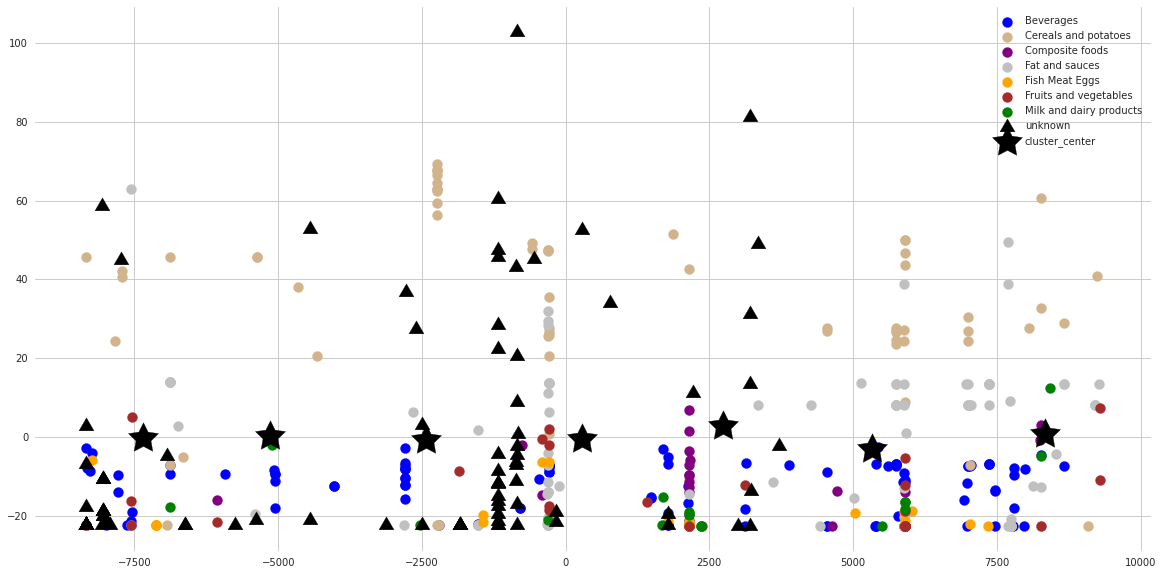

In [ ]:
scatter_x = X_trans[:500,0]
scatter_y = X_trans[:500,1]
group = y[:500]
cdict = {'Sugary snacks': 'maroon', 'Beverages': 'blue', 'Milk and dairy products': 'green', 'Cereals and potatoes': 'tan',\
         'Fish Meat Eggs': 'orange', 'Composite foods': 'purple', 'Fat and sauces': 'silver', 'Fruits and vegetables':'brown',\
         'Salty snacks':'pink'}

fig, ax = plt.subplots(figsize=(20, 10))
for g in np.unique(group):
    if g == 'Sugary snacks' or g == 'Other' or g == 'Salty snacks':
      continue
    ix = np.where(group == g)
    ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[g], label = g, s = 100)
ax.scatter(X_unknown_trans[:100,0], X_unknown_trans[:100,1], marker=(3,0), c='black', label='unknown', s=300)
ax.scatter(centers[:,0], centers[:,1], marker=(5,1), c='black', label='cluster_center', s= 1000)
ax.legend()
plt.show()

### Re-cluster unknown datapoints

Below we use the best performing supervised classifier from previous section to reclassify unknown labels and compare them to existing clusters.

#### Train classifier and predict unknown labels

In [ ]:
# Train and predict using the random forest classifier
model_random.fit(X_train, y_train)
pred_y = model_random.predict(X_unknown)

# Transform for scatter plot
X_unknown_trans = pca.transform(X_unknown)

# Filter out outliers
pred_y = pred_y[X_unknown_trans[:,0] < 20000]
pred_y = pred_y[X_unknown_trans[:,1] < 20000]
X_unknown_trans = X_unknown_trans[X_unknown_trans[:,0] < 20000]
X_unknown_trans = X_unknown_trans[X_unknown_trans[:,1] < 20000]

#### Scatter plots for reclassified labels

Below we see the scatter plot with previously unknown label being reclassified using the model we trained above. We see that most of the unknown datapoints actually line up reasonable well into existing clusters.

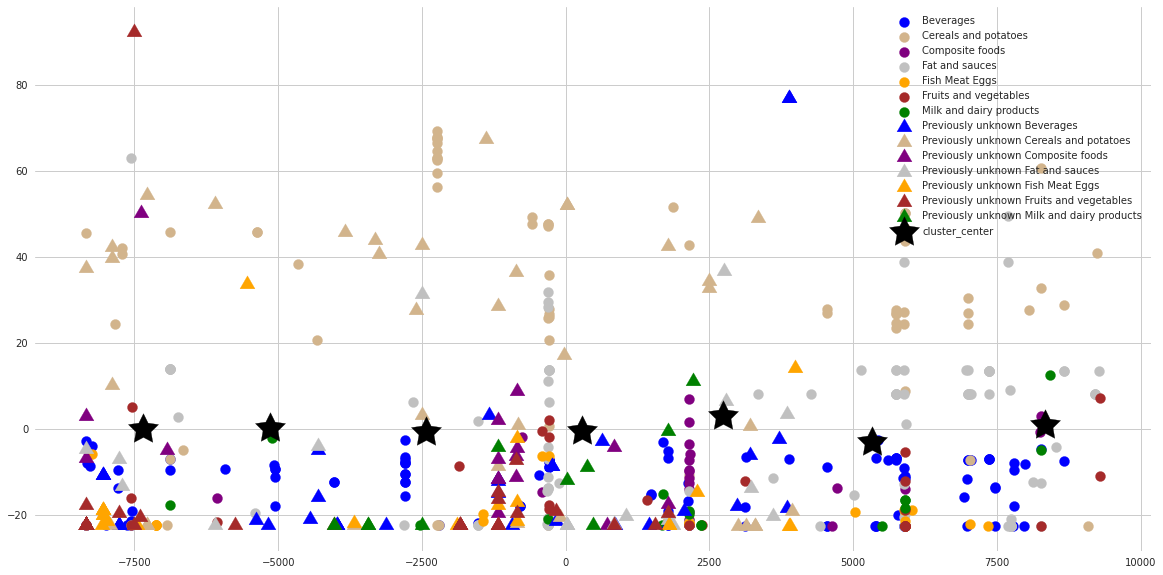

In [ ]:
scatter_x = X_trans[:500,0]
scatter_y = X_trans[:500,1]
group = y[:500]
cdict = {'Sugary snacks': 'maroon', 'Beverages': 'blue', 'Milk and dairy products': 'green', 'Cereals and potatoes': 'tan',\
         'Fish Meat Eggs': 'orange', 'Composite foods': 'purple', 'Fat and sauces': 'silver', 'Fruits and vegetables':'brown',\
         'Salty snacks':'pink'}

fig, ax = plt.subplots(figsize=(20, 10))
for g in np.unique(group):
    if g == 'Sugary snacks' or g == 'Other' or g == 'Salty snacks':
      continue
    ix = np.where(group == g)
    ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[g], label = g, s = 100)

scatter_x = X_unknown_trans[:300,0]
scatter_y = X_unknown_trans[:300,1]
group = pred_y[:300]
for g in np.unique(group):
    if g == 'Sugary snacks' or g == 'Other' or g == 'Salty snacks':
      continue
    ix = np.where(group == g)
    ax.scatter(scatter_x[ix], scatter_y[ix], marker=(3,0), c = cdict[g], label = 'Previously unknown ' + g, s = 300)

# ax.scatter(X_unknown_trans[:200,0], X_unknown_trans[:200,1], marker=(3,0), c='black', label='unknown', s=300)
# ax.scatter(X_nan_trans[:100,1], X_nan_trans[:100,0], marker=(4,0), c='navy', label='nan', s=100)
ax.scatter(centers[:,0], centers[:,1], marker=(5,1), c='black', label='cluster_center', s= 1000)
ax.legend()
plt.show()

# Conclusion

We started out by asking whether or not we could use nutritional content and brand tags to identify food category and whether we could reclassify all the datapoints in the unknown food category.

For the first part, we trained various supervised learning models using 5-fold cross validation. We then settled on random forest classifier that achieved very high test accuracy. To answer the second question, we performed a PCA decompostition and two principal components to perform a clustering analysis. Finally, we reclassified datapoints in the unknown food category and compared it against datapoints in known food categories using the random forest classifier. We found that this method performed reasonably well.